In [25]:
import pandas as pd
import requests
import zipfile
import io, os
import openpyxl
from pathlib import Path
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn

In [26]:
import sys
print(sys.executable)
import seaborn as sns
import plotly.graph_objects as go
sys.path.append(".")
import visualizations

import importlib
importlib.reload(visualizations)


/home/m/myenv/bin/python


<module 'visualizations' from '/home/m/aZTProgr/pr3/projekt3/src/visualizations.py'>

## Podział pracy:
* zad 2 i 3: Maja Domańska
* zad 1 i 4: Joanna Huba

## wczytanie danych

In [27]:
DATA_DIR = Path("../data/processed")

df_ex2 = pd.read_csv(DATA_DIR / "df_ex2.csv")
df_ex4 = pd.read_csv(DATA_DIR / "df_ex4.csv")
monthly_PM25 = pd.read_csv(DATA_DIR / "monthly_PM25.csv")

# 2. Średnie miesięczne + trend dla miast

In [28]:
from pathlib import Path
import pandas as pd
import sys

from means import make_trend_df, trend_sanity_summary

DATA_DIR = Path("../data/processed")
df_ex2 = pd.read_csv(DATA_DIR / "df_ex2.csv")

trend_df = make_trend_df(df_ex2, years=(2015, 2024))

summary = trend_sanity_summary(trend_df)
print("Lata w trend_df:", summary["years_present"])
print("Miasta w trend_df:", summary["cities_present"])

print("\nLiczba miesięcy w trend_df (miasto × rok):")
display(summary["months_per_city_year"])

print("\nŚrednie PM2.5 dla każdego miasta i roku w trend_df:")
display(summary["mean_pm25_city_year"])

display(trend_df.head(10))

Lata w trend_df: [2015, 2024]
Miasta w trend_df: ['Katowice', 'Warszawa']

Liczba miesięcy w trend_df (miasto × rok):


year,2015,2024
city,,
Katowice,7,12
Warszawa,8,12



Średnie PM2.5 dla każdego miasta i roku w trend_df:


city      year
Katowice  2015    39.267960
          2024    18.513139
Warszawa  2015    26.852051
          2024    14.636462
Name: PM2.5, dtype: float64

,year,month,city,PM2.5
0,2015,1,Katowice,44.549000
1,2015,2,Katowice,19.860900
2,2015,3,Katowice,33.920467
3,2015,5,Katowice,81.653400
4,2015,8,Katowice,41.198750
5,2015,9,Katowice,17.189000
6,2015,11,Katowice,36.504200
7,2024,1,Katowice,22.559091
8,2024,2,Katowice,15.224101
9,2024,3,Katowice,14.864236


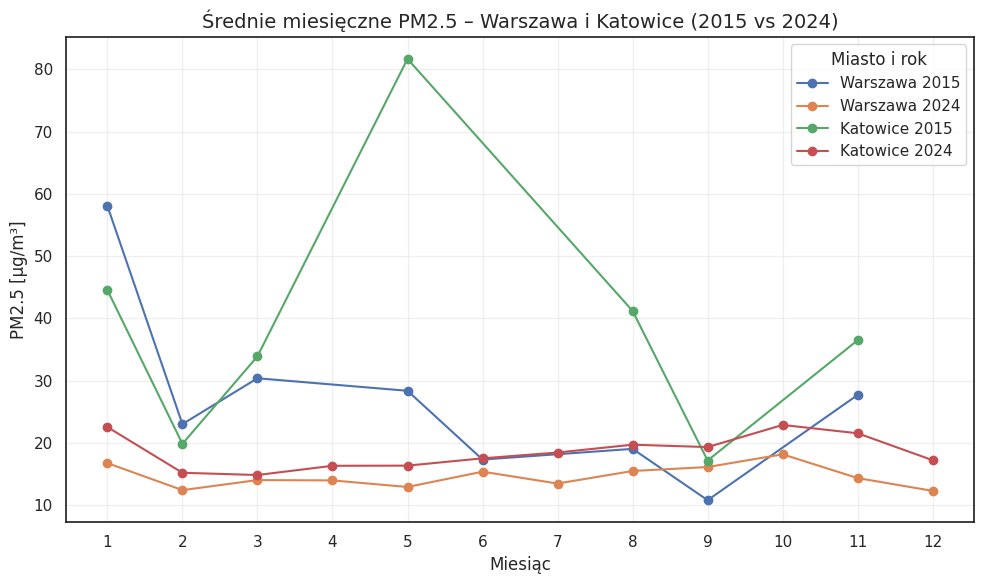

In [29]:
# wykres
from visualizations import plot_city_trends
fig= plot_city_trends(trend_df)
plt.show()

### Obserwacje i interpretacja:
- w 2024 zarówno w Warszawie jak i w Katowicach średnie stężenia PM2.5 są niskie. w każdym miesiącu Katowice mają wyższe wartości od Warszawy. W obu miastach średnio wyższe wartości obserwujemy zimą.
- w 2015 obserwujemy wysokie stężenia PM2.5. Wartości z Katowic są wyższe od Warszawy.

Porównanie lat 2015 i 2024 wskazuje na **wyraźną poprawę jakości powietrza**.
W obu miastach średnie miesięczne stężenia PM2.5 zmalały, co sugeruje skuteczność działań ograniczających emisję zanieczyszczeń. 
Mimo poprawy, **Katowice nadal są bardziej zanieczyszczone niż Warszawa**.

## 3. Heatmapa miesięcznych średnich

Lata w df_ex3: [2015, 2018, 2021, 2024]
Zakres PM2.5: 3.7 - 206.839


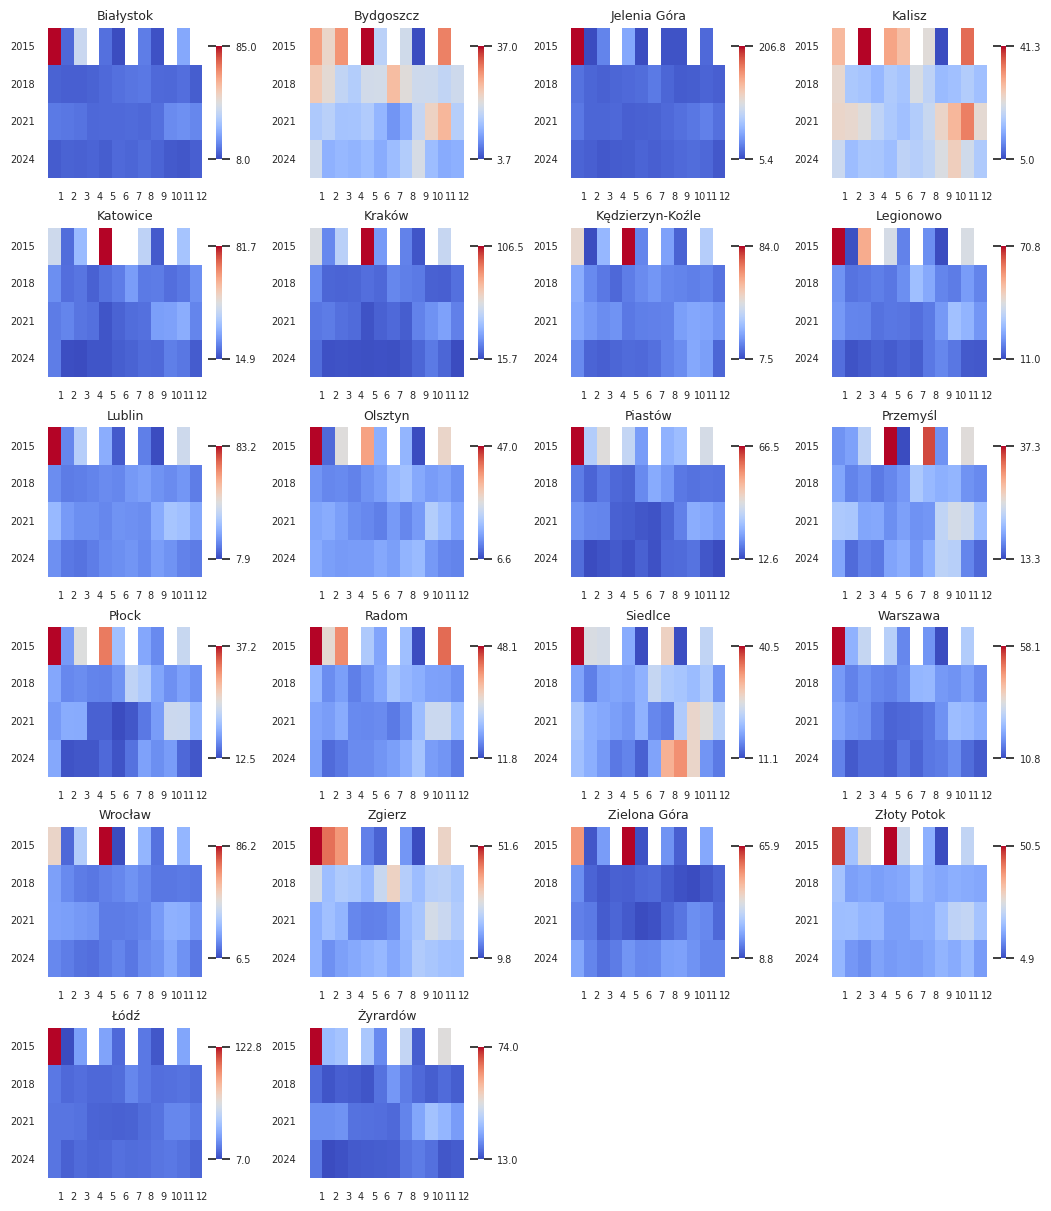

In [30]:
from means import prepare_ex3_heatmap_df, heatmap_sanity_summary

df_ex3 = prepare_ex3_heatmap_df(monthly_PM25)
summary3 = heatmap_sanity_summary(df_ex3)
cities_ex3 = sorted(df_ex3["city"].unique())

print("Lata w df_ex3:", summary3["years_present"])
print("Zakres PM2.5:", summary3["pm25_min"], "-", summary3["pm25_max"])

from visualizations import plot_city_heatmaps
fig = plot_city_heatmaps(df_ex3, cities=cities_ex3)
plt.show()

### Obserwacje:
- W 2015 roku dane są niepełne, ale we wszystkich miastach wartości stężenia PM2.5 są najwyższe.
- W 2018 roku widać już wyraźną poprawę w każdym mieście.
- Najmniejsze stężenia PM2.5 obserwujemy w latach 2021 i 2024. W większości miast w 2024 stężenia są najniższe, wyjątkiem są Siedlce Zielona Góra i Zgierz.
  
Heatmapy pokazują poprawę jakości powietrza.

## 4. Dni z przekroczeniem normy (WHO)

In [32]:
pio.renderers.default = "jupyterlab"
pio.renderers.default = "notebook_connected"

# Pick 6 stations based on 2024
df_2024 = df_ex4[df_ex4["year"] == 2024]
top3 = df_2024.nlargest(3, "exceeded")
bottom3 = df_2024.nsmallest(3, "exceeded")
stations_6 = pd.concat([top3, bottom3])["station"].unique()

# Filter full data for these stations
top_low_df = df_ex4[df_ex4["station"].isin(stations_6)].copy()

# Prepare plot
station_groups = top_low_df["station"].unique()
years = sorted(top_low_df["year"].unique())
years = top_low_df["year"].unique()

bars = []
colors = ['#7FB3D5',
          '#1F618D',
          '#F4D03F',
          '#C0392B',
          '#008080',
          '#40B0A6']

 
# Generate bars: one color group
for i, station in enumerate(station_groups):
    df = top_low_df[top_low_df["station"] == station]
    bar = go.Bar(
        x=df["year"],
        y=df["exceeded"],
        name=station, 
        marker=dict(color=colors[i])
    )
    bars.append(bar)

# Create figure
fig = go.Figure(data=bars)
fig.update_layout(
    font=dict(
        family="Liberation Serif",  
        size=20,                 
        color="#2C3E50"            
    ),
    barmode='group',
    title=dict(
        text="Dni z przekroczeniem normy (WHO)",
        x=0.5, 
        xanchor='center',
        font=dict(
            family="Liberation Serif",  
            size=35,
            color="#2C3E50"
        )
    ),
    xaxis_title="Rok",
    yaxis_title="Liczba przekroczonych dni",
)
fig.write_html("exceeded_days_plot.html")
fig.show()

## Analiza
Na podstawie wykresu można zauważyć ogólny trend spadkowy liczby dni z przekroczeniem dobowej normy PM2.5 między rokiem 2014 a 2024 dla większości analizowanych stacji. Wskazuje to na poprawę jakości powietrza w badanym okresie.

Warto jednak podkreślić, że nie wszystkie stacje wykazują jednolity spadek w każdym roku. Przykładowo, dla stacji **LdZgieMielcz** obserwujemy wzrost liczby przekroczeń między 2014 a 2019 rokiem, zanim nastąpił ponowny spadek w roku 2024. Oznacza to, że poprawa jakości powietrza nie następowała w tym przypadku w sposób liniowy.

Podsumowując — mimo pewnych wyjątków, najbardziej charakterystycznym wzorcem jest wyraźna redukcja liczby dni z przekroczeniami normy PM2.5 do roku 2024, co sugeruje skuteczniejsze działania antysmogowe i/lub korzystniejsze warunki atmosferyczne.
